# Brazilian E-commerce Data Analysis

This notebook imports all CSV files from the Brazilian e-commerce dataset and creates a table relationship diagram to understand the data structure.

## Dataset Overview
The dataset contains information about orders, customers, products, sellers, payments, and reviews from a Brazilian e-commerce platform.

In [12]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import networkx as nx
import os
from pathlib import Path

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

print("Libraries imported successfully!")

Libraries imported successfully!


In [13]:
# Define data directory and file paths
data_dir = Path("data")

# Dictionary to store all datasets
datasets = {}

# List all CSV files in the data directory
csv_files = {
    'customers': 'olist_customers_dataset.csv',
    'geolocation': 'olist_geolocation_dataset.csv',
    'order_items': 'olist_order_items_dataset.csv',
    'order_payments': 'olist_order_payments_dataset.csv',
    'order_reviews': 'olist_order_reviews_dataset.csv',
    'orders': 'olist_orders_dataset.csv',
    'products': 'olist_products_dataset.csv',
    'sellers': 'olist_sellers_dataset.csv',
    'product_category_translation': 'product_category_name_translation.csv'
}

# Import all CSV files
for name, filename in csv_files.items():
    file_path = data_dir / filename
    if file_path.exists():
        datasets[name] = pd.read_csv(file_path)
        print(f"✓ Loaded {name}: {datasets[name].shape}")
    else:
        print(f"✗ File not found: {filename}")

print(f"\nTotal datasets loaded: {len(datasets)}")

✓ Loaded customers: (99441, 5)
✓ Loaded geolocation: (1000163, 5)
✓ Loaded geolocation: (1000163, 5)
✓ Loaded order_items: (112650, 7)
✓ Loaded order_payments: (103886, 5)
✓ Loaded order_items: (112650, 7)
✓ Loaded order_payments: (103886, 5)
✓ Loaded order_reviews: (99224, 7)
✓ Loaded order_reviews: (99224, 7)
✓ Loaded orders: (99441, 8)
✓ Loaded products: (32951, 9)
✓ Loaded sellers: (3095, 4)
✓ Loaded product_category_translation: (71, 2)

Total datasets loaded: 9
✓ Loaded orders: (99441, 8)
✓ Loaded products: (32951, 9)
✓ Loaded sellers: (3095, 4)
✓ Loaded product_category_translation: (71, 2)

Total datasets loaded: 9


In [14]:
# Display basic information about each dataset
print("=== DATASET OVERVIEW ===\n")

for name, df in datasets.items():
    print(f"📊 {name.upper().replace('_', ' ')}")
    print(f"   Shape: {df.shape}")
    print(f"   Columns: {list(df.columns)}")
    print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print("-" * 80)

=== DATASET OVERVIEW ===

📊 CUSTOMERS
   Shape: (99441, 5)
   Columns: ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']
   Memory usage: 26.59 MB
--------------------------------------------------------------------------------
📊 GEOLOCATION
   Shape: (1000163, 5)
   Columns: ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']
   Memory usage: 129.38 MB
--------------------------------------------------------------------------------
📊 ORDER ITEMS
   Shape: (112650, 7)
   Columns: ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
   Memory usage: 35.99 MB
--------------------------------------------------------------------------------
📊 ORDER PAYMENTS
   Shape: (103886, 5)
   Columns: ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']
   Memory usage: 16.23 MB
-----------------------

In [15]:
# Analyze potential relationships between tables by examining column names
print("=== POTENTIAL TABLE RELATIONSHIPS ===\n")

# Define potential foreign key relationships based on column names
relationships = []

# Check for matching columns that could indicate relationships
for table1_name, table1_df in datasets.items():
    for table2_name, table2_df in datasets.items():
        if table1_name != table2_name:
            # Find common columns
            common_columns = set(table1_df.columns) & set(table2_df.columns)
            
            # Look for columns that might be foreign keys
            for col in common_columns:
                if col.endswith('_id') or col in ['customer_id', 'order_id', 'product_id', 'seller_id']:
                    relationships.append({
                        'from_table': table1_name,
                        'to_table': table2_name,
                        'column': col
                    })

# Display identified relationships
for rel in relationships:
    print(f"🔗 {rel['from_table']} -> {rel['to_table']} (via {rel['column']})")

print(f"\nTotal relationships identified: {len(relationships)}")

=== POTENTIAL TABLE RELATIONSHIPS ===

🔗 customers -> orders (via customer_id)
🔗 order_items -> order_payments (via order_id)
🔗 order_items -> order_reviews (via order_id)
🔗 order_items -> orders (via order_id)
🔗 order_items -> products (via product_id)
🔗 order_items -> sellers (via seller_id)
🔗 order_payments -> order_items (via order_id)
🔗 order_payments -> order_reviews (via order_id)
🔗 order_payments -> orders (via order_id)
🔗 order_reviews -> order_items (via order_id)
🔗 order_reviews -> order_payments (via order_id)
🔗 order_reviews -> orders (via order_id)
🔗 orders -> customers (via customer_id)
🔗 orders -> order_items (via order_id)
🔗 orders -> order_payments (via order_id)
🔗 orders -> order_reviews (via order_id)
🔗 products -> order_items (via product_id)
🔗 sellers -> order_items (via seller_id)

Total relationships identified: 18


In [18]:
# Display detailed table schemas and sample data
print("=== DETAILED TABLE SCHEMAS ===\n")

for name, df in datasets.items():
    print(f"📋 {name.upper().replace('_', ' ')} TABLE")
    print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    
    # Display column information
    print("\nColumn Details:")
    for i, (col, dtype) in enumerate(zip(df.columns, df.dtypes), 1):
        null_count = df[col].isnull().sum()
        null_pct = (null_count / len(df)) * 100
        unique_count = df[col].nunique()
        print(f"  {i:2d}. {col:<30} | {str(dtype):<10} | Nulls: {null_count:>6} ({null_pct:5.1f}%) | Unique: {unique_count:>8}")
    
    # Display sample data
    print(f"\nSample Data (first 3 rows):")
    print(df.head(3).to_string(index=False))
    print("=" * 100)
    print()

=== DETAILED TABLE SCHEMAS ===

📋 CUSTOMERS TABLE
Shape: 99,441 rows × 5 columns

Column Details:
   1. customer_id                    | object     | Nulls:      0 (  0.0%) | Unique:    99441
   2. customer_unique_id             | object     | Nulls:      0 (  0.0%) | Unique:    96096
   3. customer_zip_code_prefix       | int64      | Nulls:      0 (  0.0%) | Unique:    14994
   4. customer_city                  | object     | Nulls:      0 (  0.0%) | Unique:     4119
   5. customer_state                 | object     | Nulls:      0 (  0.0%) | Unique:       27

Sample Data (first 3 rows):
                     customer_id               customer_unique_id  customer_zip_code_prefix         customer_city customer_state
06b8999e2fba1a1fbc88172c00ba8bc7 861eff4711a542e4b93843c6dd7febb0                     14409                franca             SP
18955e83d337fd6b2def6b18a428ac77 290c77bc529b7ac935b93aa66c333dc3                      9790 sao bernardo do campo             SP
4e7b3e00288586eb

## Key Insights - Database Structure

### Central Tables
- **Orders**: The central fact table containing order information
- **Customers**: Customer demographic and location data
- **Products**: Product catalog with categories
- **Sellers**: Seller information and locations

### Transaction Tables
- **Order Items**: Individual items within each order (many-to-many relationship)
- **Order Payments**: Payment methods and installment details
- **Order Reviews**: Customer feedback and ratings

### Reference Tables
- **Geolocation**: Geographic coordinates for zip codes
- **Product Category Translation**: Portuguese to English translations

### Main Relationships
1. `Orders` ↔ `Customers` (via customer_id)
2. `Orders` ↔ `Order Items` (via order_id) 
3. `Order Items` ↔ `Products` (via product_id)
4. `Order Items` ↔ `Sellers` (via seller_id)
5. `Orders` ↔ `Order Payments` (via order_id)
6. `Orders` ↔ `Order Reviews` (via order_id)

This structure follows a typical e-commerce star schema with Orders as the central fact table.

## Instacart Dataset Entity Relationship Diagram

The following section creates an entity relationship diagram for the Instacart Market Basket Analysis dataset, which is commonly used for recommendation systems and market basket analysis.

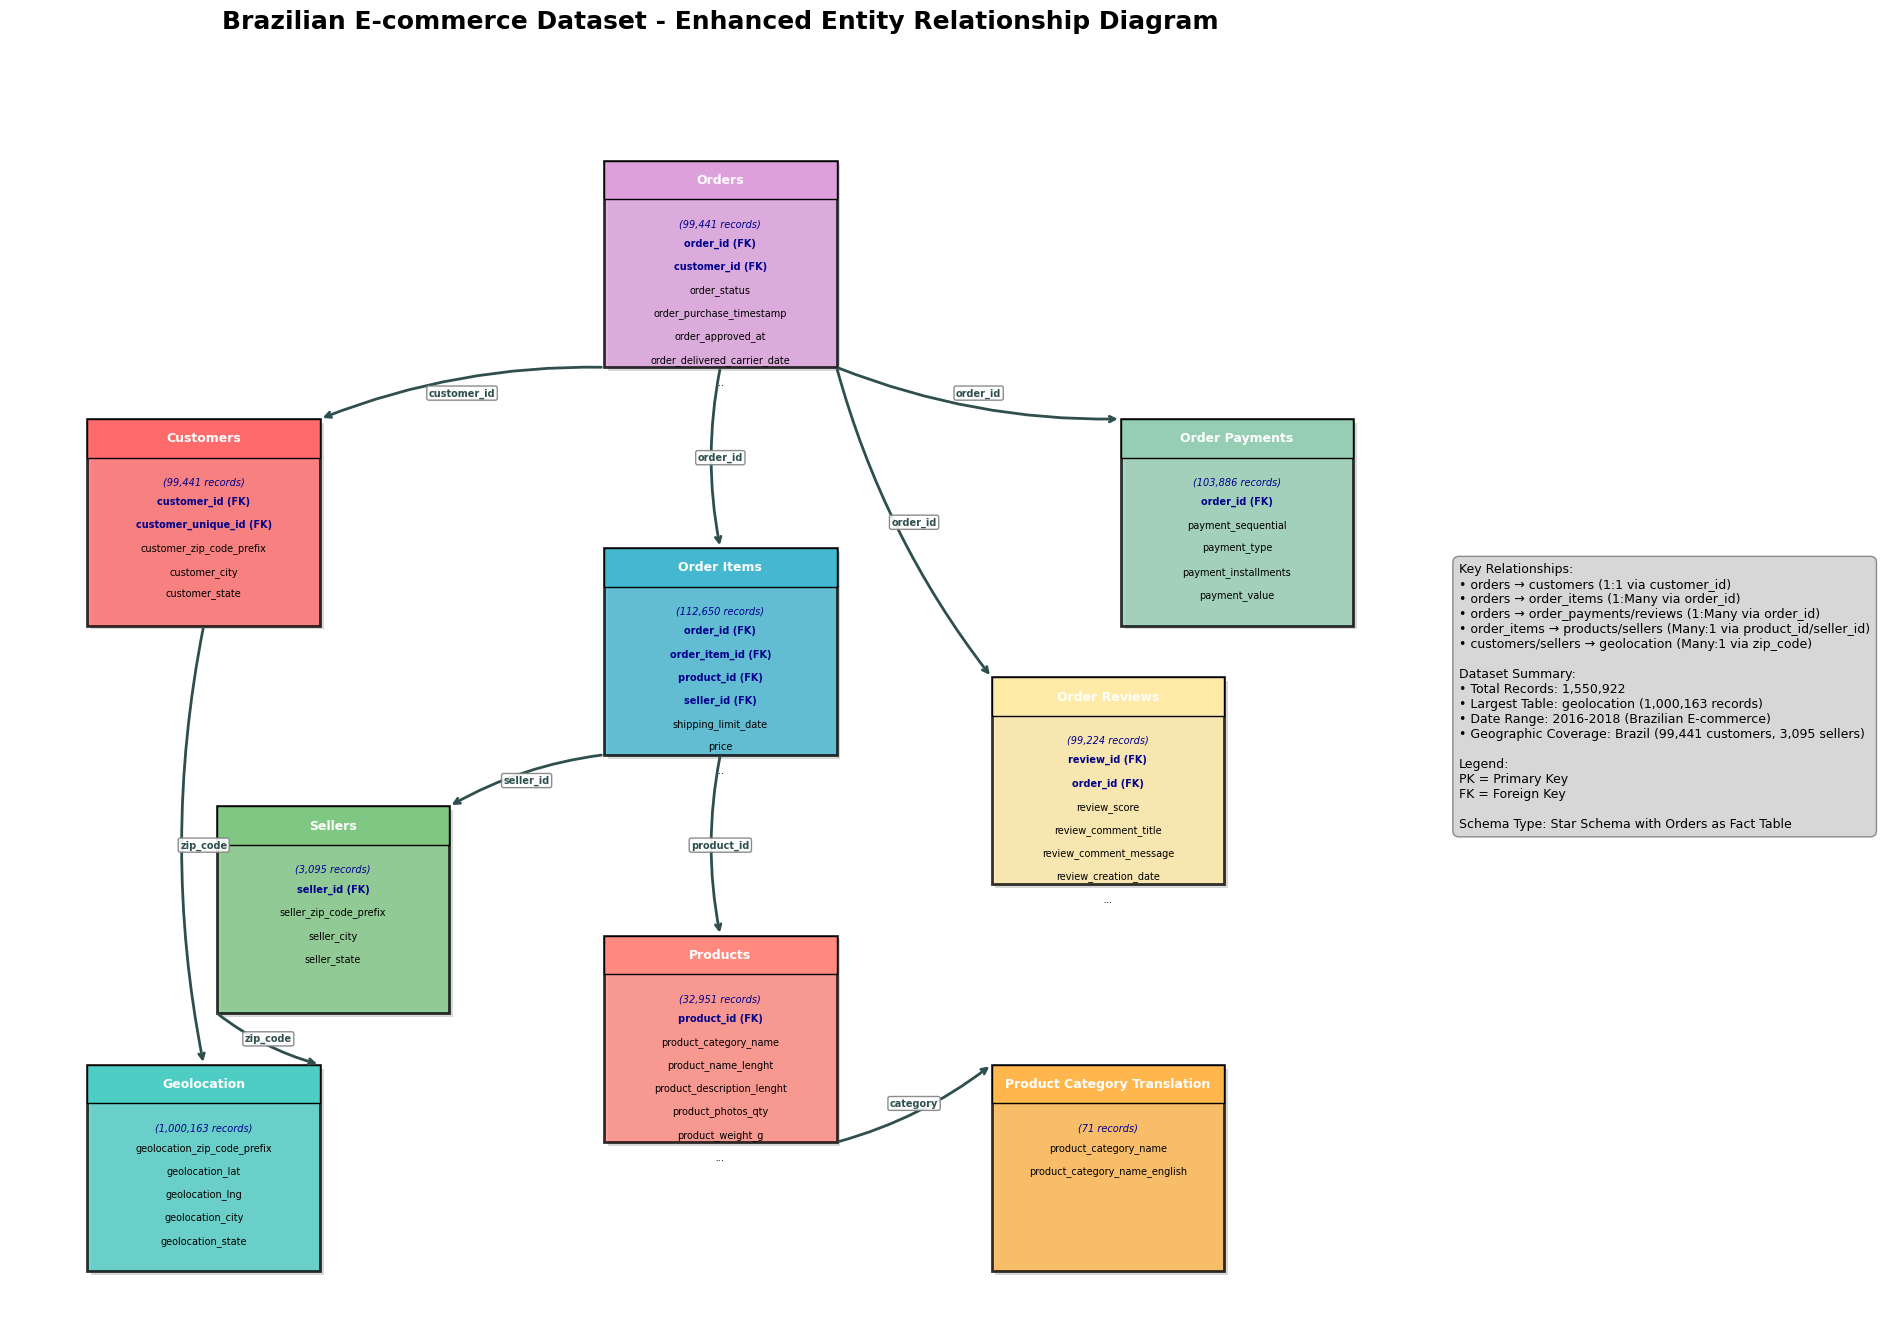

In [20]:
# Create Enhanced Entity Relationship Diagram for Brazilian E-commerce Dataset
def create_brazilian_ecommerce_er_diagram():
    """
    Creates a detailed entity relationship diagram for the Brazilian E-commerce dataset
    using the actual loaded data with table details and professional styling
    """
    fig, ax = plt.subplots(1, 1, figsize=(18, 14))

    # Define positions for each table (x, y coordinates between 0 and 1)
    positions = {
        'orders': (0.5, 0.8),
        'customers': (0.1, 0.6),
        'order_items': (0.5, 0.5),
        'order_payments': (0.9, 0.6),
        'order_reviews': (0.8, 0.4),
        'products': (0.5, 0.2),
        'sellers': (0.2, 0.3),
        'geolocation': (0.1, 0.1),
        'product_category_translation': (0.8, 0.1)
    }

    # Define table information using actual loaded data
    table_info = {}
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#FF8A80', '#81C784', '#FFB74D']
    
    for i, (name, df) in enumerate(datasets.items()):
        # Get key columns (those containing 'id')
        key_columns = [col for col in df.columns if 'id' in col.lower()]
        other_columns = [col for col in df.columns if 'id' not in col.lower()]
        
        # Format columns with PK/FK indicators
        formatted_columns = []
        for col in df.columns[:8]:  # Show first 8 columns
            if col.endswith('_id') or col in ['customer_id', 'order_id', 'product_id', 'seller_id']:
                if name.replace('_', '') in col or col == f"{name.replace('_', '')}_id":
                    formatted_columns.append(f"{col} (PK)")
                else:
                    formatted_columns.append(f"{col} (FK)")
            else:
                formatted_columns.append(col)
        
        table_info[name] = {
            'columns': formatted_columns,
            'color': colors[i % len(colors)],
            'records': f"{df.shape[0]:,}",
            'size': df.shape
        }

    # Draw tables
    for table_name, pos in positions.items():
        if table_name not in table_info:
            continue
            
        x, y = pos
        info = table_info[table_name]
        
        # Create table box dimensions
        box_width = 0.18
        box_height = 0.16
        
        # Draw main table box with shadow effect
        shadow = plt.Rectangle((x - box_width/2 + 0.003, y - box_height/2 - 0.003), 
                              box_width, box_height, 
                              facecolor='gray', alpha=0.3)
        ax.add_patch(shadow)
        
        # Draw main table box
        rect = plt.Rectangle((x - box_width/2, y - box_height/2), box_width, box_height, 
                            facecolor=info['color'], edgecolor='black', linewidth=2, alpha=0.8)
        ax.add_patch(rect)
        
        # Add table header (darker shade)
        header_rect = plt.Rectangle((x - box_width/2, y + box_height/2 - 0.03), box_width, 0.03,
                                   facecolor=info['color'], edgecolor='black', linewidth=1, alpha=1.0)
        ax.add_patch(header_rect)
        
        # Add table name
        display_name = table_name.replace('_', ' ').title()
        ax.text(x, y + box_height/2 - 0.015, display_name, 
                ha='center', va='center', fontweight='bold', fontsize=9, color='white')
        
        # Add record count
        ax.text(x, y + box_height/2 - 0.045, f"({info['records']} records)", 
                ha='center', va='top', fontsize=7, style='italic', color='darkblue')
        
        # Add columns with proper formatting
        col_y_start = y + box_height/2 - 0.06
        for i, col in enumerate(info['columns'][:6]):  # Show first 6 columns
            col_y = col_y_start - (i * 0.018)
            # Highlight primary keys and foreign keys
            if '(PK)' in col:
                ax.text(x, col_y, col, ha='center', va='top', fontsize=7, 
                       fontweight='bold', color='darkred')
            elif '(FK)' in col:
                ax.text(x, col_y, col, ha='center', va='top', fontsize=7, 
                       fontweight='bold', color='darkblue')
            else:
                ax.text(x, col_y, col, ha='center', va='top', fontsize=7)
        
        if len(info['columns']) > 6:
            ax.text(x, col_y_start - (6 * 0.018), '...', ha='center', va='top', fontsize=7, style='italic')

    # Draw relationships based on actual data structure
    relationships = [
        ('orders', 'customers', 'customer_id'),
        ('orders', 'order_items', 'order_id'),
        ('orders', 'order_payments', 'order_id'),
        ('orders', 'order_reviews', 'order_id'),
        ('order_items', 'products', 'product_id'),
        ('order_items', 'sellers', 'seller_id'),
        ('customers', 'geolocation', 'zip_code'),
        ('sellers', 'geolocation', 'zip_code'),
        ('products', 'product_category_translation', 'category')
    ]

    for source, target, key in relationships:
        if source not in positions or target not in positions:
            continue
            
        x1, y1 = positions[source]
        x2, y2 = positions[target]
        
        # Calculate connection points on the edge of boxes
        if x1 < x2:  # Source is to the left
            x1_conn = x1 + 0.09
            x2_conn = x2 - 0.09
        elif x1 > x2:  # Source is to the right
            x1_conn = x1 - 0.09
            x2_conn = x2 + 0.09
        else:  # Same x coordinate
            x1_conn = x1
            x2_conn = x2
            
        if y1 > y2:  # Source is above
            y1_conn = y1 - 0.08
            y2_conn = y2 + 0.08
        else:  # Source is below
            y1_conn = y1 + 0.08
            y2_conn = y2 - 0.08
        
        # Draw arrow with connection style
        ax.annotate('', xy=(x2_conn, y2_conn), xytext=(x1_conn, y1_conn),
                    arrowprops=dict(arrowstyle='->', lw=2, color='darkslategray',
                                  connectionstyle="arc3,rad=0.1"))
        
        # Add relationship label with background
        mid_x, mid_y = (x1_conn + x2_conn) / 2, (y1_conn + y2_conn) / 2
        ax.text(mid_x, mid_y, key, ha='center', va='center', 
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='gray', alpha=0.9),
                fontsize=7, fontweight='bold', color='darkslategray')

    # Set plot limits and appearance
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.02, 0.95)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Brazilian E-commerce Dataset - Enhanced Entity Relationship Diagram', 
                fontsize=18, fontweight='bold', pad=30)

    # Add comprehensive legend with actual data insights
    total_records = sum(df.shape[0] for df in datasets.values())
    legend_text = f"""Key Relationships:
• orders → customers (1:1 via customer_id)
• orders → order_items (1:Many via order_id)
• orders → order_payments/reviews (1:Many via order_id)
• order_items → products/sellers (Many:1 via product_id/seller_id)
• customers/sellers → geolocation (Many:1 via zip_code)

Dataset Summary:
• Total Records: {total_records:,}
• Largest Table: {max(datasets.items(), key=lambda x: x[1].shape[0])[0]} ({max(df.shape[0] for df in datasets.values()):,} records)
• Date Range: 2016-2018 (Brazilian E-commerce)
• Geographic Coverage: Brazil (99,441 customers, 3,095 sellers)

Legend:
PK = Primary Key
FK = Foreign Key

Schema Type: Star Schema with Orders as Fact Table"""

    ax.text(1.02, 0.5, legend_text, transform=ax.transAxes, fontsize=9,
            bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', 
                     edgecolor='gray', alpha=0.9),
            verticalalignment='center')

    plt.tight_layout()
    plt.show()

# Create the enhanced Brazilian E-commerce ER diagram with actual data
create_brazilian_ecommerce_er_diagram()